##Eye Disease Detection using Transfer Learning (VGG19)

Notebook ini berisi pemodelan Transfer Learning yang digunakan untuk mendeteksi Penyakit Mata berdasarkan data citra fundus Retina. Dataset yang digunakan data citra penyakit mata yang terdiri dari kelas katarak, diabetik retinopati, glaukoma dan normal. Dalam prosesnya untuk memudahkan dalam monitoring training maka digunakan custom callback. Custom callback ini berguna untuk mengatur seberapa banyak epoch yang digunakan. Saat melakukan proses training terdapat fungsi H (halt) untuk menghentikan training yang sedang berjalan kemudian mengatur kembali epoch dan F untuk melanjutkan training.

##1. Import Library

In [2]:
pip install tensorflow keras numpy pandas tqdm scikit-learn matplotlib seaborn pillow opencv-python


Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

C:\Users\RISKI ABDILAH\AppData\Local\Temp\ipykernel_17996\2804052335.py:24: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


2. Define fungsi untuk menampilkan contoh Training Image

In [4]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

3. Define fungsi untuk print text dalam RGB dan Background Colors

In [5]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

4. Define subclass dari Keras callbacks untuk mengontrol Learning Rate dan print training data dalam format spreadsheet. Callback disini juga berfungsi untuk menanyakan secara berkala apakah lanjut training selama N epoch atau Halt (berhenti)

In [6]:
class LRA(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, dwell, batches, initial_epoch, epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.dwell = dwell
        self.batches = batches
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        v_loss = logs.get('val_loss')
        v_acc = logs.get('val_accuracy')

        if v_loss < 0.05 and v_acc > 0.95:
            msg = f'Pelatihan dihentikan karena kinerja sudah cukup baik di epoch {epoch+1}.'
            print_in_color(msg, (0, 255, 255), (55, 65, 80))
            self.model.stop_training = True
        elif self.stop_count > self.stop_patience - 1:
            msg = f'Pelatihan dihentikan setelah {self.stop_patience} pengurangan LR tanpa perbaikan.'
            print_in_color(msg, (0, 255, 255), (55, 65, 80))
            self.model.stop_training = True


5. Define fungsi untuk plot training data

In [7]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


6. Define fungsi untuk membuat confusion matrix dan classification report

In [8]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

7. Define fungsi untuk menyimpan model dan associated class_dict.csv file

In [9]:
def saver(save_path, model, model_name, subject, accuracy,img_size, scalar, generator):
    # first save the model
    save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color ('model was saved as ' + model_save_loc, (0,255,0),(55,65,80))
    # now create the class_df and convert to csv file
    class_dict=generator.class_indices
    height=[]
    width=[]
    scale=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class')
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)
    csv_name='class_dict.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False)
    print_in_color ('class csv file was saved as ' + csv_save_loc, (0,255,0),(55,65,80))
    return model_save_loc, csv_save_loc

8. Define fungsi menggunakan trained model dan class_dict.csv file untuk prediksi citras

In [10]:
def classify(sdir, csv_path,  model_path, crop_image = False):
    # read in the csv file
    class_df=pd.read_csv(csv_path)
    img_height=int(class_df['height'].iloc[0])
    img_width =int(class_df['width'].iloc[0])
    img_size=(img_height, img_width)
    scale=class_df['scale by'].iloc[0]
    try:
        s=int(scale)
        s2=1
        s1=0
    except:
        split=scale.split('-')
        s1=float(split[1])
        s2=float(split[0].split('*')[1])
        print (s1,s2)
    path_list=[]
    paths=os.listdir(sdir)
    for f in paths:
        path_list.append(os.path.join(sdir,f))
    print (' Model is being loaded- this will take about 10 seconds')
    model=load_model(model_path)
    image_count=len(path_list)
    index_list=[]
    prob_list=[]
    cropped_image_list=[]
    good_image_count=0
    for i in range (image_count):
        img=plt.imread(path_list[i])
        if crop_image == True:
            status, img=crop(img)
        else:
            status=True
        if status== True:
            good_image_count +=1
            img=cv2.resize(img, img_size)
            print ('image shape is ', img.shape)
            cropped_image_list.append(img)
            img=img*s2 - s1
            img=np.expand_dims(img, axis=0)
            p= np.squeeze (model.predict(img))
            index=np.argmax(p)
            print(index)
            prob=p[index]
            index_list.append(index)
            prob_list.append(prob)
    if good_image_count==1:
        class_name= class_df['class'].iloc[index_list[0]]
        probability= prob_list[0]
        img=cropped_image_list [0]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
        plt.imshow(img)
        return class_name, probability
    elif good_image_count == 0:
        return None, None
    most=0
    for i in range (len(index_list)-1):
        key= index_list[i]
        keycount=0
        for j in range (i+1, len(index_list)):
            nkey= index_list[j]
            if nkey == key:
                keycount +=1
        if keycount> most:
            most=keycount
            isave=i
    best_index=index_list[isave]
    psum=0
    bestsum=0
    for i in range (len(index_list)):
        psum += prob_list[i]
        if index_list[i]==best_index:
            bestsum += prob_list[i]
    img= cropped_image_list[isave]/255
    class_name=class_df['class'].iloc[best_index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
    plt.imshow(img)
    return class_name, bestsum/image_count

9. Import Image/Citra

In [11]:
import zipfile
import pandas as pd
import os

# Path ke file ZIP
zip_file_path = r"C:\Users\RISKI ABDILAH\OneDrive\Desktop\Project SCP Research\archive.zip"  # Gunakan 'r' untuk raw string agar path Windows diterima

# Lokasi untuk ekstraksi file
extract_to = "Eye_Diseases"  # Direktori tempat file akan diekstrak

# Ekstrak file ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)  # Ekstrak semua file ke folder 'extracted_data'

# Dapatkan daftar file dalam folder ekstraksi
extracted_files = []
for root, _, files in os.walk(extract_to):
    for file in files:
        extracted_files.append(os.path.join(root, file))  # Simpan path lengkap setiap file

print("File yang diekstrak:")
for file in extracted_files:
    print(file)

# Temukan dan baca semua file CSV
csv_files = [file for file in extracted_files if file.endswith(".csv")]

if csv_files:
    print("\nFile CSV yang ditemukan:")
    for csv_file in csv_files:
        print(csv_file)
        try:
            # Baca setiap file CSV
            data = pd.read_csv(csv_file)
            print(f"\nData dari file {os.path.basename(csv_file)}:")
            print(data.head())  # Tampilkan 5 baris pertama
        except Exception as e:
            print(f"Error membaca file {csv_file}: {e}")
else:
    print("Tidak ada file CSV yang ditemukan di dalam ZIP.")


File yang diekstrak:
Eye_Diseases\dataset\cataract\0_left.jpg
Eye_Diseases\dataset\cataract\103_left.jpg
Eye_Diseases\dataset\cataract\1062_right.jpg
Eye_Diseases\dataset\cataract\1083_left.jpg
Eye_Diseases\dataset\cataract\1084_right.jpg
Eye_Diseases\dataset\cataract\1102_left.jpg
Eye_Diseases\dataset\cataract\1102_right.jpg
Eye_Diseases\dataset\cataract\1115_left.jpg
Eye_Diseases\dataset\cataract\1126_right.jpg
Eye_Diseases\dataset\cataract\112_right.jpg
Eye_Diseases\dataset\cataract\1144_left.jpg
Eye_Diseases\dataset\cataract\1144_right.jpg
Eye_Diseases\dataset\cataract\1164_left.jpg
Eye_Diseases\dataset\cataract\1167_right.jpg
Eye_Diseases\dataset\cataract\119_left.jpg
Eye_Diseases\dataset\cataract\1285_left.jpg
Eye_Diseases\dataset\cataract\1415_left.jpg
Eye_Diseases\dataset\cataract\1415_right.jpg
Eye_Diseases\dataset\cataract\1435_left.jpg
Eye_Diseases\dataset\cataract\1444_left.jpg
Eye_Diseases\dataset\cataract\1452_left.jpg
Eye_Diseases\dataset\cataract\1454_right.jpg
Eye_Dise

10. Import citra

(256, 256, 3)


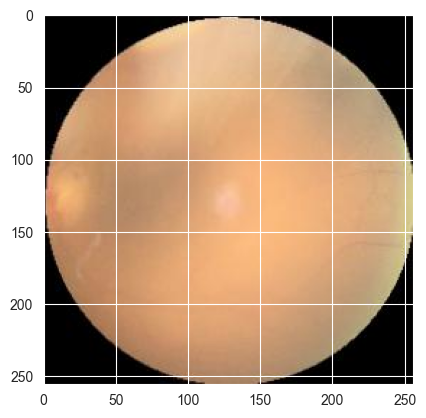

In [12]:
import matplotlib.pyplot as plt # Add this line at the beginning of the cell
fpath=r'C:\Users\RISKI ABDILAH\OneDrive\Desktop\Project SCP Research\Eye_Diseases\dataset\cataract\_1_5346540.jpg'
img=plt.imread(fpath) # Now 'plt' is recognized
print (img.shape)
plt.imshow(img) # Use plt.imshow instead of just imshow

11. Iterate direktori data dan membuat data frame kedalam filepaths dan labels

In [13]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Direktori dataset
sdir = r'C:\Users\RISKI ABDILAH\OneDrive\Desktop\Project SCP Research\Eye_Diseases\dataset'

# Membuat daftar file paths dan label
classlist = os.listdir(sdir)
filepaths = []
labels = []

for klass in classlist:
    classpath = os.path.join(sdir, klass)
    if os.path.isdir(classpath):  # Pastikan hanya folder yang diproses
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

# Membuat dataframe dari filepaths dan labels
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

# Membagi data ke dalam train, validation, dan test set
trsplit = 0.9  # Proporsi data training
vsplit = 0.05  # Proporsi data validasi
dsplit = vsplit / (1 - trsplit)  # Proporsi data validasi terhadap sisa data

train_df, dummy_df = train_test_split(df, train_size=trsplit, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123)

# Menampilkan informasi jumlah data
print('train_df length:', len(train_df), ' test_df length:', len(test_df), ' valid_df length:', len(valid_df))

# Menampilkan distribusi label pada training set
balance = train_df['labels'].value_counts()
print("\nDistribusi label di training set:")
for label, count in balance.items():
    print(f"{label}: {count}")


train_df length: 3795  test_df length: 211  valid_df length: 211

Distribusi label di training set:
diabetic_retinopathy: 992
normal: 961
cataract: 933
glaucoma: 909


12. Karena dataset misbalanced maka dilakukan limit sample data di tiap kelas menjadi 906 supaya balance

In [14]:
sample_list=[]
max_size= 906
min_size = 0
groups=train_df.groupby('labels')
for label in train_df['labels'].unique():
    group=groups.get_group(label)
    sample_count=len(group)
    if sample_count> max_size :
        samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
        sample_list.append(samples)
    elif sample_count>= min_size:
        sample_list.append(group)
train_df=pd.concat(sample_list, axis=0).reset_index(drop=True)
balance=list(train_df['labels'].value_counts())
print (balance)

[906, 906, 906, 906]


13. Membuat train, test, valid generators

In [15]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameter dasar
height = 224
width = 224
channels = 3
batch_size = 40
img_shape = (height, width, channels)
img_size = (height, width)

# Menghitung test batch size dan steps
length = len(test_df)
test_batch_size = sorted(
    [int(length / n) for n in range(1, length + 1) if length % n == 0 and length / n <= 80],
    reverse=True
)[0]
test_steps = int(length / test_batch_size)

print('Test batch size:', test_batch_size, ' Test steps:', test_steps)

# Fungsi preprocessing (scalar)
def scalar(img):
    """Fungsi preprocessing untuk memastikan skala piksel tetap dalam rentang 0-255,
    sesuai dengan kebutuhan EfficientNet."""
    return img

# ImageDataGenerator untuk data augmentation dan preprocessing
trgen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen = ImageDataGenerator(preprocessing_function=scalar)

# Data generator untuk training, validation, dan testing
train_gen = trgen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = tvgen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = tvgen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)

# Mendapatkan daftar kelas dan jumlah kelas
classes = list(train_gen.class_indices.keys())
class_count = len(classes)

# Menghitung jumlah langkah per epoch untuk training
train_steps = np.ceil(len(train_gen.labels) / batch_size)

# Informasi tambahan
print('Classes:', classes)
print('Number of classes:', class_count)
print('Train steps per epoch:', train_steps)


Test batch size: 1  Test steps: 211
Found 3624 validated image filenames belonging to 4 classes.
Found 211 validated image filenames belonging to 4 classes.
Found 211 validated image filenames belonging to 4 classes.
Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Number of classes: 4
Train steps per epoch: 91.0


14. Membuat fungsi untuk menampilkan beberapa sample citra dari penyakit mata

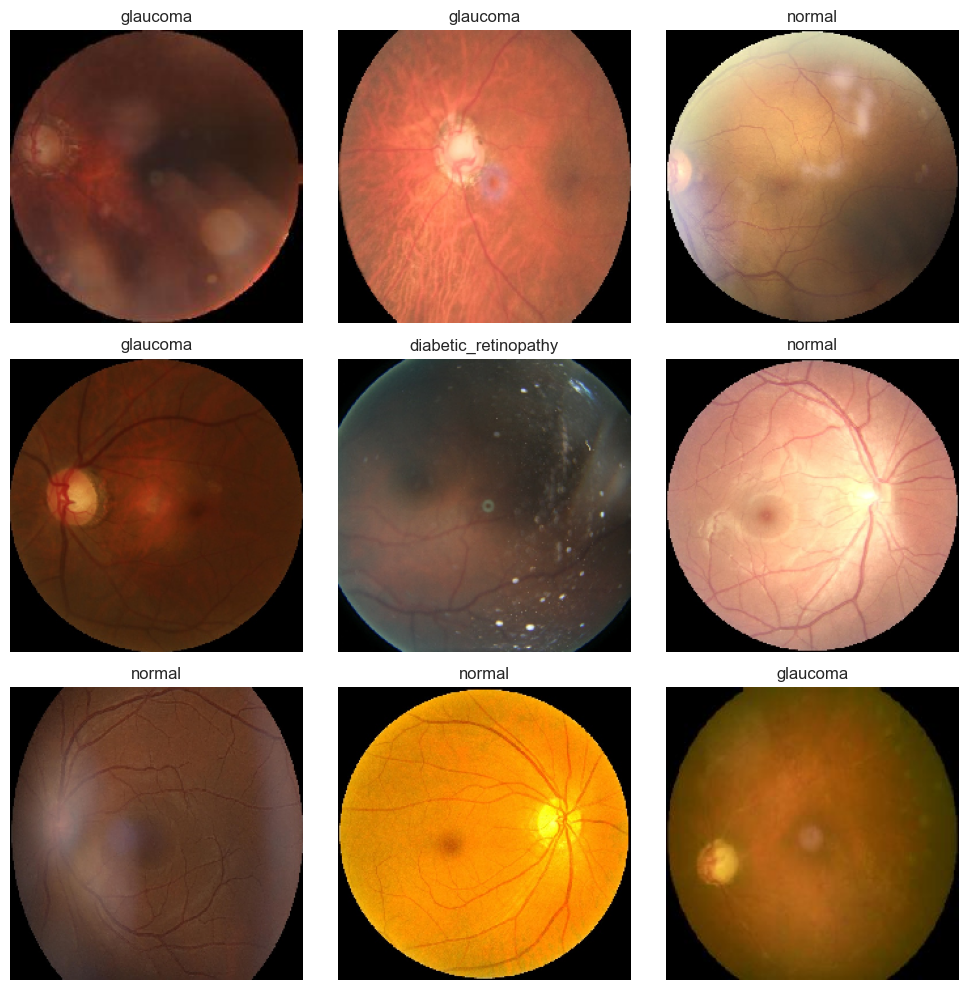

In [16]:
import matplotlib.pyplot as plt

def show_image_samples(generator, num_samples=9):
    """Menampilkan sampel gambar dari generator.

    Args:
        generator: Generator data (misalnya train_gen).
        num_samples: Jumlah gambar untuk ditampilkan (default: 9).
    """
    # Ambil satu batch dari generator
    images, labels = next(generator)

    # Batasi jumlah gambar sesuai num_samples
    images = images[:num_samples]
    labels = labels[:num_samples]

    # Menampilkan gambar
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(int(num_samples**0.5), int(num_samples**0.5), i + 1)
        plt.imshow(images[i].astype("uint8"))  # Pastikan tipe data sesuai untuk ditampilkan
        label = list(generator.class_indices.keys())[np.argmax(labels[i])]
        plt.title(label)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk menampilkan sampel gambar
show_image_samples(train_gen)


15. Membuat model VGG-19

In [17]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

# Nama model
model_name = 'VGG19'

# Arsitektur VGG19 dengan penyesuaian
base_model = VGG19(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Menambahkan lapisan kustom
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(
    256,
    kernel_regularizer=regularizers.l2(0.016),
    activity_regularizer=regularizers.l1(0.006),
    bias_regularizer=regularizers.l1(0.006),
    activation='relu'
)(x)
x = Dropout(rate=0.45)(x)
output = Dense(class_count, activation='softmax')(x)

# Membuat model
model = Model(inputs=base_model.input, outputs=output)

# Kompilasi model
model.compile(
    optimizer=Adamax(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Ringkasan model
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 20,158,788 (76.90 MB)

 Trainable params: 20,157,764 (76.90 MB)

 Non-trainable params: 1,024 (4.00 KB)

16. Membuat instance callback dengan nilai tertentu dan training model

c:\Users\RISKI ABDILAH\anaconda3\envs\MyProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 154s/step - accuracy: 0.2716 - loss: 9.6998  
Epoch 1: val_loss improved from inf to 6.56489, saving model to best_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 14309s 156s/step - accuracy: 0.2714 - loss: 9.6567 - val_accuracy: 0.2227 - val_loss: 6.5649 - learning_rate: 0.0100
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 138s/step - accuracy: 0.2527 - loss: 2.7576  
Epoch 2: val_loss improved from 6.56489 to 2.24030, saving model to best_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 12712s 140s/step - accuracy: 0.2527 - loss: 2.7548 - val_accuracy: 0.2180 - val_loss: 2.2403 - learning_rate: 0.0100
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 177s/step - accuracy: 0.2355 - loss: 1.9399  
Epoch 3: val_loss improved from 2.24030 to 1.69826, saving model to best_model.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 16310s 179s/step - accuracy: 0.2355 - loss: 1.9388 - val_accuracy: 0.2512 - val_loss: 1.6983 - learning_rate: 0.0100
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 176s/step - acc

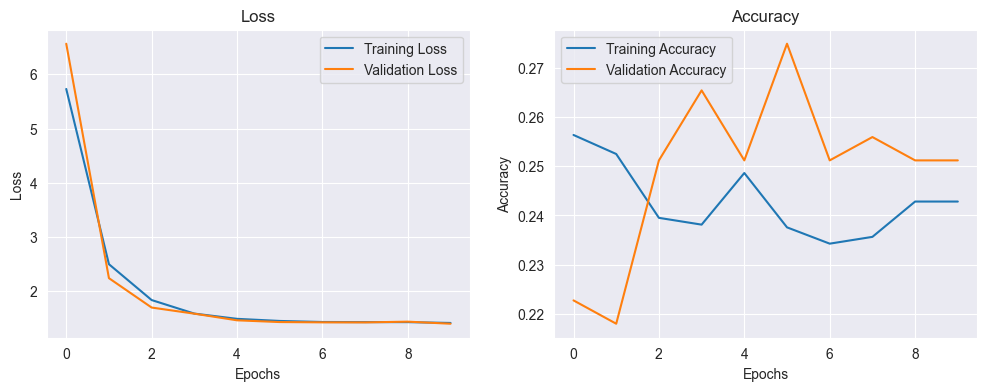

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Parameter Pelatihan
epochs = 10  # Jumlah total epoch
patience = 1  # Epoch tanpa peningkatan sebelum learning rate diturunkan
stop_patience = 3  # Epoch tanpa peningkatan sebelum pelatihan dihentikan
threshold = 0.9  # Jika akurasi pelatihan < threshold, monitor akurasi; jika lebih, monitor val_loss
factor = 0.5  # Faktor untuk mengurangi learning rate
freeze = False  # Jika True, layer pada base_model akan dibekukan

# Membekukan weights pada base_model jika freeze=True
if freeze:
    for layer in base_model.layers:
        layer.trainable = False

# Callback: Menyimpan model terbaik
checkpoint_cb = ModelCheckpoint(
    "best_model.keras",  # Nama file untuk menyimpan model terbaik
    monitor="val_loss",  # Metode monitoring
    save_best_only=True,  # Simpan hanya model terbaik
    verbose=1
)

# Callback: Menghentikan pelatihan jika tidak ada peningkatan
early_stopping_cb = EarlyStopping(
    monitor="val_loss",  # Metode monitoring
    patience=stop_patience,  # Berapa epoch tanpa peningkatan sebelum dihentikan
    restore_best_weights=True,  # Kembali ke bobot terbaik
    verbose=1
)

# Callback: Mengurangi learning rate jika tidak ada peningkatan
reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",  # Metode monitoring
    factor=factor,  # Faktor pengurangan learning rate
    patience=patience,  # Berapa epoch tanpa peningkatan sebelum learning rate dikurangi
    verbose=1
)

# Daftar callback
callbacks = [checkpoint_cb, early_stopping_cb, reduce_lr_cb]

# Melatih model
history = model.fit(
    x=train_gen,           # Data generator atau dataset untuk pelatihan
    epochs=epochs,         # Jumlah epoch
    verbose=1,             # Tingkat logging (1 untuk progres penuh)
    callbacks=callbacks,   # Daftar callback yang digunakan
    validation_data=valid_gen,  # Data validasi
    shuffle=False,         # Tidak perlu shuffle jika menggunakan generator
    initial_epoch=0        # Mulai dari epoch ke-0
)

# Evaluasi Akurasi Setelah Pelatihan
print("\nEvaluasi akurasi setelah pelatihan:")
train_loss, train_accuracy = model.evaluate(train_gen, verbose=1)
valid_loss, valid_accuracy = model.evaluate(valid_gen, verbose=1)

print(f"Akurasi pada set pelatihan: {train_accuracy * 100:.2f}%")
print(f"Akurasi pada set validasi: {valid_accuracy * 100:.2f}%")

# Visualisasi History Pelatihan
def plot_training_history(history):
    """Plot grafik loss dan akurasi dari history pelatihan."""
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot akurasi
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.show()

# Tampilkan grafik hasil pelatihan
plot_training_history(history)


In [17]:
train_dir = r"C:\Users\RISKI ABDILAH\OneDrive\Desktop\Project SCP Research\Eye_Diseases\dataset"
valid_dir = r"C:\Users\RISKI ABDILAH\OneDrive\Desktop\Project SCP Research\Eye_Diseases\dataset"

# Cek apakah direktori benar
import os
print("Train directory exists:", os.path.exists(train_dir))
print("Valid directory exists:", os.path.exists(valid_dir))


Train directory exists: True
Valid directory exists: True


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# **1. Data Generator**
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Direktori Dataset
train_dir = r"C:\Users\RISKI ABDILAH\OneDrive\Desktop\Project SCP Research\Eye_Diseases\dataset" 
valid_dir = r"C:\Users\RISKI ABDILAH\OneDrive\Desktop\Project SCP Research\Eye_Diseases\dataset"  

# Generator Data
train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
valid_gen = valid_datagen.flow_from_directory(
    valid_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)

# **2. Model Pretrained**
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Tambahkan fully connected layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(train_gen.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Membekukan layer base model
for layer in base_model.layers:
    layer.trainable = False

# **3. Kompilasi Model**
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# **4. Callbacks**
checkpoint_cb = ModelCheckpoint(
    "best_vgg19_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1
)

early_stopping_cb = EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.5, patience=2, verbose=1
)

callbacks = [checkpoint_cb, early_stopping_cb, reduce_lr_cb]

# **5. Pelatihan Model**
history = model.fit(
    x=train_gen,
    epochs=30,
    verbose=1,
    callbacks=callbacks,
    validation_data=valid_gen,
    shuffle=True
)

# **6. Fine-Tuning**
# Unfreeze some layers in the base model for fine-tuning
for layer in base_model.layers[-4:]:  # Unfreeze the last 4 layers
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train again
fine_tune_history = model.fit(
    x=train_gen,
    epochs=10,
    verbose=1,
    callbacks=callbacks,
    validation_data=valid_gen,
    shuffle=True
)

# **7. Evaluasi Akurasi**
train_loss, train_accuracy = model.evaluate(train_gen, verbose=1)
valid_loss, valid_accuracy = model.evaluate(valid_gen, verbose=1)

print(f"Akurasi pada set pelatihan: {train_accuracy * 100:.2f}%")
print(f"Akurasi pada set validasi: {valid_accuracy * 100:.2f}%")

# **8. Visualisasi History**
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Tampilkan grafik hasil pelatihan
plot_training_history(history)
plot_training_history(fine_tune_history)


Found 4217 images belonging to 4 classes.
Found 4217 images belonging to 4 classes.


c:\Users\RISKI ABDILAH\anaconda3\envs\MyProject\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.2543 - loss: 1.5366 
Epoch 1: val_accuracy improved from -inf to 0.39815, saving model to best_vgg19_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 7121s 54s/step - accuracy: 0.2545 - loss: 1.5359 - val_accuracy: 0.3982 - val_loss: 1.2688 - learning_rate: 1.0000e-04
Epoch 2/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.3780 - loss: 1.3174 
Epoch 2: val_accuracy improved from 0.39815 to 0.51411, saving model to best_vgg19_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 9205s 70s/step - accuracy: 0.3781 - loss: 1.3172 - val_accuracy: 0.5141 - val_loss: 1.1535 - learning_rate: 1.0000e-04
Epoch 3/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.4594 - loss: 1.1908 
Epoch 3: val_accuracy improved from 0.51411 to 0.58620, saving model to best_vgg19_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 8136s 62s/step - accuracy: 0.4594 - loss: 1.1906 - val_accuracy: 0.5862 - val_loss: 1.0635 - learning_rate: 1.0000e-04
Epoch 4/30
13

17. Evaluasi model pada test dataset kemudian menyimpan model

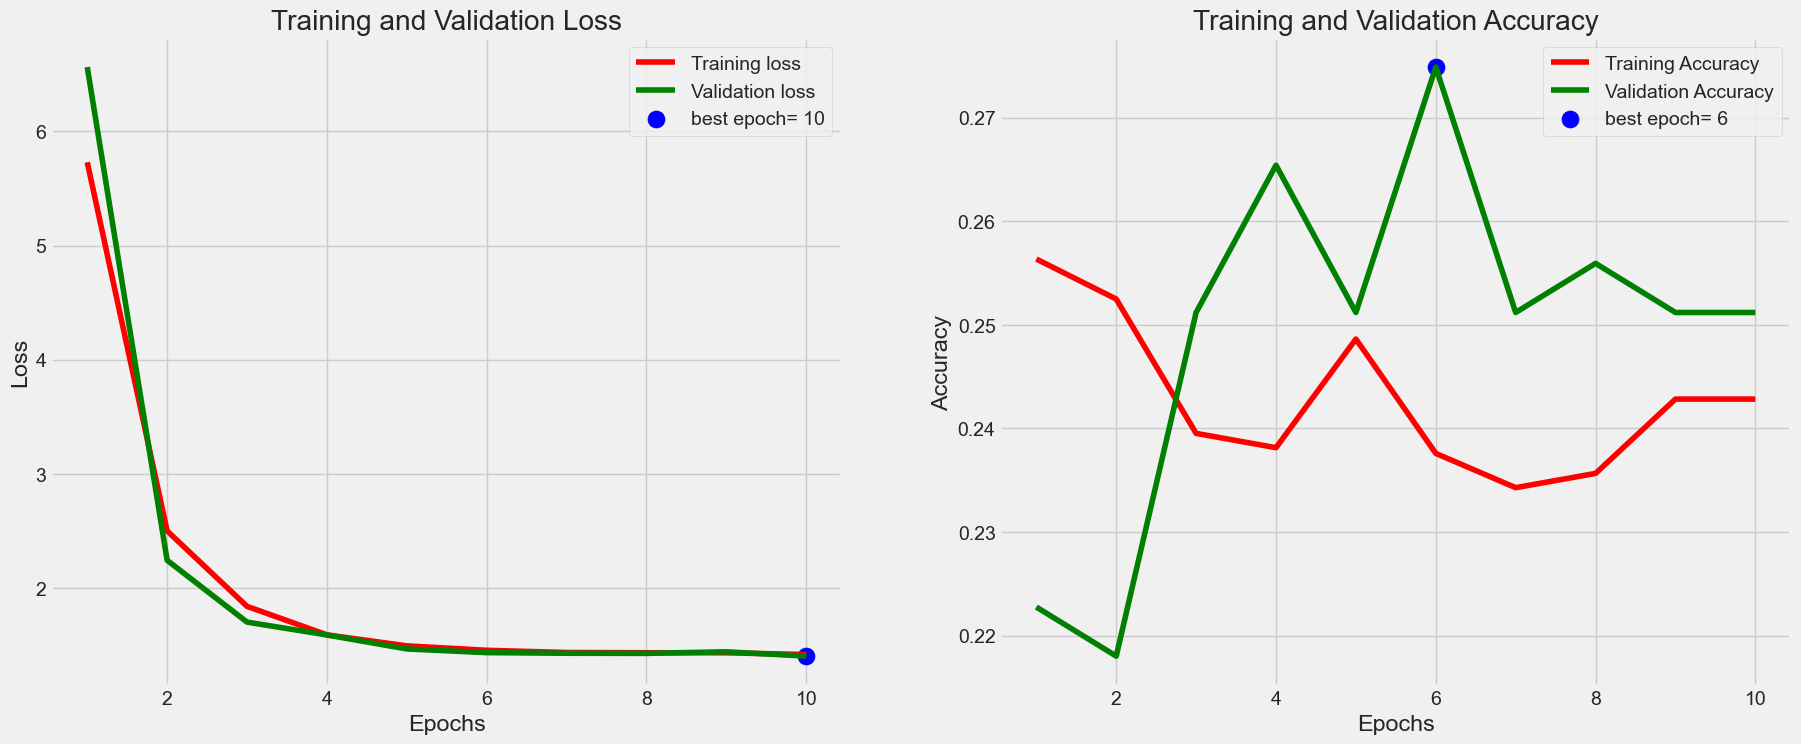

211/211 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.2181 - loss: 1.4002
accuracy on the test set is 21.33 %



model was saved as ./VGG19-eye_disease-21.32.h5

class csv file was saved as ./class_dict.csv



In [31]:
tr_plot(history,0)
save_dir='./'
subject='eye_disease'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)
generator=train_gen
scale = 1
result=saver(save_dir, model, model_name, subject, acc, img_size, scale,  generator)

18. Membuat prediksi pada test dataset kemudian generate confusion matrix dan classification report

211/211 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step


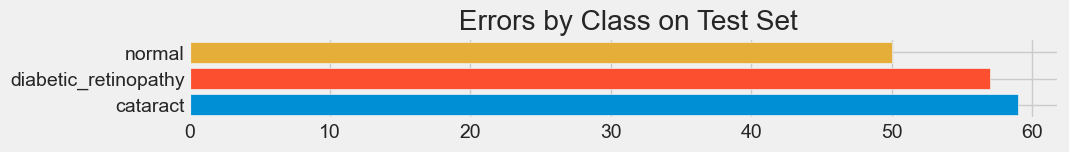

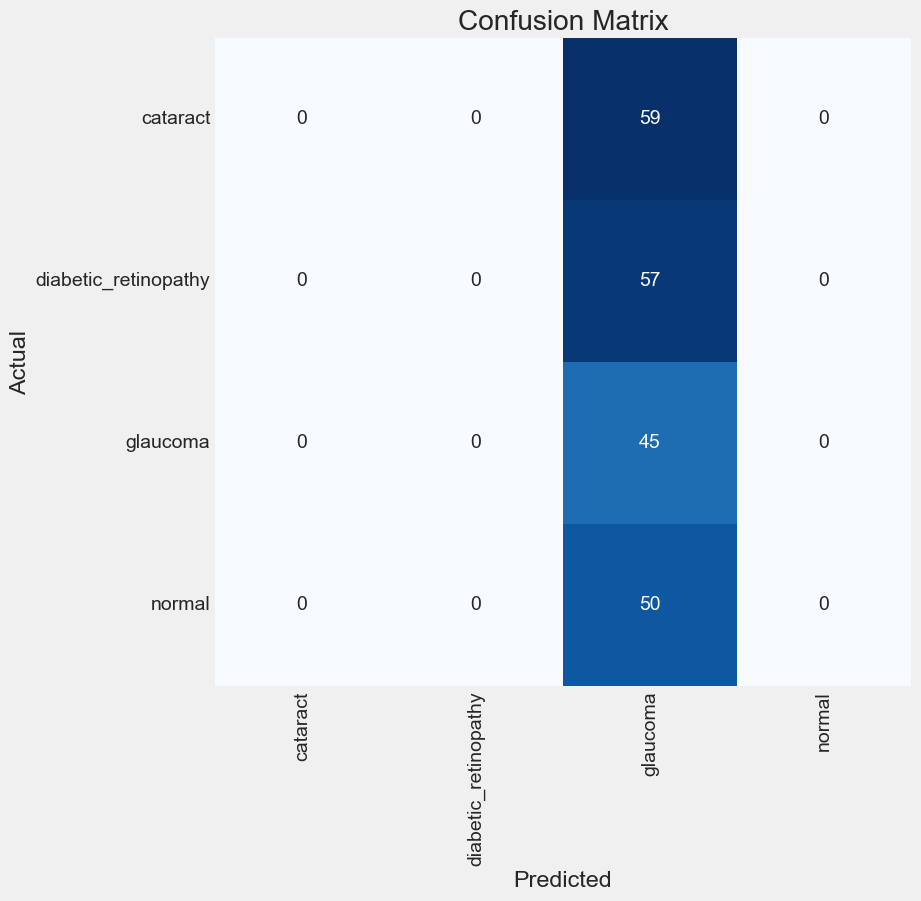

Classification Report:
----------------------
                       precision    recall  f1-score   support

            cataract       0.00      0.00      0.00        59
diabetic_retinopathy       0.00      0.00      0.00        57
            glaucoma       0.21      1.00      0.35        45
              normal       0.00      0.00      0.00        50

            accuracy                           0.21       211
           macro avg       0.05      0.25      0.09       211
        weighted avg       0.05      0.21      0.07       211



c:\Users\RISKI ABDILAH\anaconda3\envs\MyProject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RISKI ABDILAH\anaconda3\envs\MyProject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RISKI ABDILAH\anaconda3\envs\MyProject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [32]:
print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )